In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize, minimize_scalar

In [2]:
with open('SiO2Damon1973.txt', 'r') as f:
    data = f.readlines()
data = [d.split('\t') for d in data]
data = pd.DataFrame(data[1:], columns=['T', 'k'])
data['k'] = data['k'].str.replace('\n', '')
for c in data.columns:
    data[c] = data[c].astype('float')

In [3]:
data['T_log'] = np.log(data['T'])
data['k_log'] = np.log(data['k'])

In [4]:
z = np.polyfit(data['T_log'], data['k_log'], 6)
p = np.poly1d(z)
xp = np.linspace(0, 5, 100)
ap_df = pd.DataFrame({'x':xp})

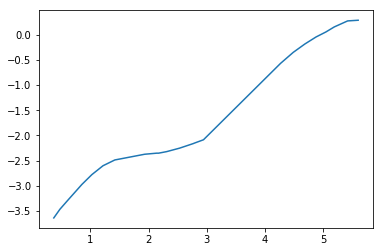

In [5]:
plt.plot(data['T_log'], data['k_log'])

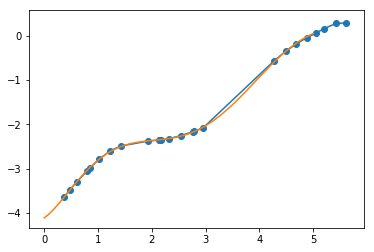

In [6]:
plt.plot(data['T_log'], data['k_log'])
plt.scatter(data['T_log'], data['k_log'])
plt.plot(xp, p(xp))

In [7]:
ap_df['y'] = [p(x) for x in xp]

In [8]:
p1 = np.polyder(p, m=1)
p2 = np.polyder(p, m=2)
p3 = np.polyder(p, m=3)
roots = np.roots(p3)

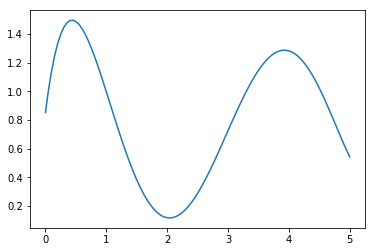

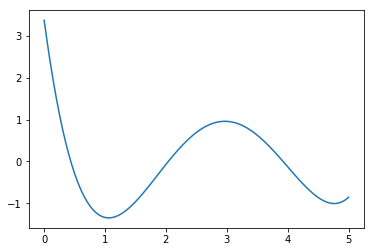

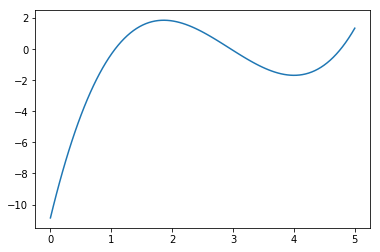

In [9]:
ap_df['yd1'] = [p1(x) for x in xp]
ap_df['yd2'] = [p2(x) for x in xp]
ap_df['yd3'] = [p3(x) for x in xp]

plt.figure()
for f in ('yd1', 'yd2', 'yd3'):
    plt.plot(ap_df['x'], ap_df[f])
    plt.show()

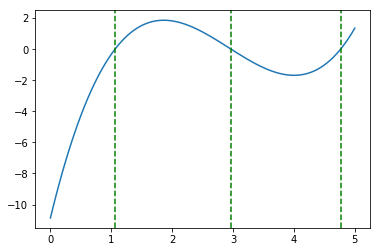

In [10]:
plt.plot(ap_df['x'], ap_df['yd3'])
for r in roots:
    plt.axvline(x=r, color='g', linestyle='--')

In [11]:
plateau = sorted(roots)[:2]
data_pl = ap_df[(ap_df['x']>plateau[0]) & (ap_df['x']<plateau[1])]

In [12]:
z_l = np.polyfit(data_pl['x'], data_pl['y'], 1)
p_l = np.poly1d(z_l)

xp_l = np.linspace(0, 4, 100)
yp_l = [p_l(x) for x  in xp_l]

In [13]:
b = list(np.linspace(data_pl['y'].min(), data_pl['y'].max(), 100))

In [14]:
def mse(w1, y):
    return np.mean((w1 - y)**2)

def f(w1):
    loss = sum([mse(w1, y) for y in data_pl['y']])
    return loss
res = minimize_scalar(f)

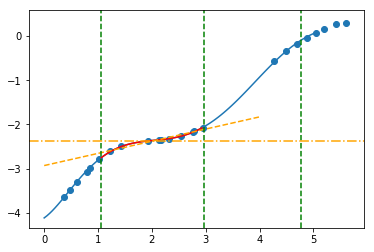

In [15]:
plt.plot(ap_df['x'], ap_df['y'])
plt.scatter(data['T_log'], data['k_log'])
plt.plot(data_pl['x'], data_pl['y'], color='r')
plt.plot(xp_l, yp_l,  color='orange', linestyle='--')
for r in roots:
    plt.axvline(x=r, color='g', linestyle='--')
plt.axhline(y=res.x, color='orange', linestyle='-.')

In [16]:
data_pl['ae'] = [res.x - y for y in data_pl['y']]

/home/quantum/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([3., 2., 4., 7., 9., 4., 3., 2., 2., 2.]),
 array([-0.30160039, -0.23449977, -0.16739916, -0.10029855, -0.03319793,
         0.03390268,  0.10100329,  0.16810391,  0.23520452,  0.30230514,
         0.36940575]),
 <a list of 10 Patch objects>)

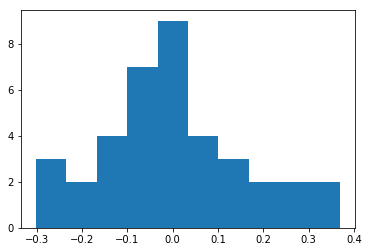

In [17]:
plt.hist(data_pl['ae'])

In [18]:
var = np.var(data_pl['ae'])

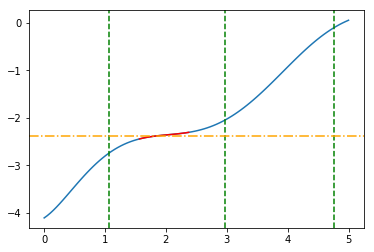

In [19]:
data_pl_f = data_pl[data_pl['ae'].abs()<3*var]
plt.plot(ap_df['x'], ap_df['y'])
#plt.scatter(data['T_log'], data['k_log'])
plt.plot(data_pl_f['x'], data_pl_f['y'], color='r')
#plt.plot(xp_l, yp_l,  color='orange', linestyle='--')
for r in roots:
    plt.axvline(x=r, color='g', linestyle='--')
plt.axhline(y=res.x, color='orange', linestyle='-.')

In [20]:
def k1(T, sigma, betta, k_pl):
    return k_pl * (betta * T**(2-sigma))/(k_pl + (betta * T**(2-sigma)))

def k2(T, k0, E):
    return k0*np.exp(-E/T)

In [21]:
k_pl = np.exp(data_pl_f['y'].mean())
T = np.exp(ap_df['x'])
k = np.exp(ap_df['y'])

In [22]:
ap_df.columns

Index(['x', 'y', 'yd1', 'yd2', 'yd3'], dtype='object')

In [23]:
T_bel_pl = np.exp(ap_df[ap_df['x']< roots[1]]['x'])
k_bel_pl = np.exp(ap_df[ap_df['x']< roots[1]]['y'])

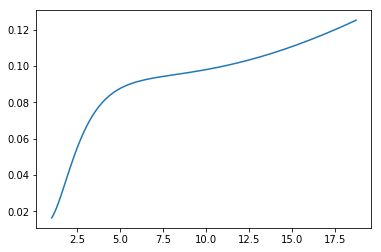

In [24]:
plt.plot(T_bel_pl, k_bel_pl)

In [25]:
def k1(T, c1, c2, n):
    return c1 * c2 * T**(n)/(c2 + c1 * T**(n))

In [27]:
def loss_k1(*params):
    c1 = params[0][0]
    c2 = params[0][1]
    n = params[0][2]
    k_fit = k1(T_bel_pl, c1, c2, n)
    return np.mean((k_fit - k_bel_pl)**2)

In [28]:
k1_params = minimize(loss_k1, (0.5, 0.2, 1), 
         method='SLSQP', 
         tol=1e-10, 
         options={'maxiter':10000}
                 )
k1_params

     fun: 1.6282322745618355e-05
     jac: array([-7.14732346e-06, -1.30071498e-06, -1.95672783e-07])
 message: 'Optimization terminated successfully.'
    nfev: 260
     nit: 45
    njev: 45
  status: 0
 success: True
       x: array([0.01901942, 0.11251829, 1.85365978])

In [29]:
с1, c2, n = k1_params.x
k_pred = k1(T_bel_pl, с1, c2, n)
loss_k1([с1, c2, n])

1.6282322745618355e-05

(0, 0.2)

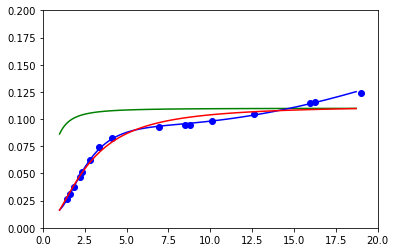

In [30]:
plt.plot(T_bel_pl, k1(T_bel_pl, 0.4, 0.11, 1.8), color='g')
plt.scatter(data['T'], data['k'], color='b')
plt.plot(T_bel_pl, k_bel_pl, color='b')
plt.plot(T_bel_pl, k1(T_bel_pl, с1, c2, n), color='r')
plt.xlim((0, 20)) 
plt.ylim((0, 0.2)) 

In [36]:
с1, c2, n = tuple(k1_params.x.tolist())
print(с1, c2, n)

0.019019419068931672 0.112518288593089 1.8536597821561973


In [26]:
def k2(T, c3, c4):
    return c3*np.exp(c4 / T)

In [40]:
def loss_k2(*params):
    print(params)
    c3 = params[0][0]
    c4 = params[0][1]
    k_fit = k1(T, с1, c2, n) + k2(T, c3, c4)
    return np.mean((k_fit - k)**2)

In [46]:
k2_params = minimize(loss_k2, (1.8, 15), 
         method='SLSQP', 
         tol=1e-10, 
         options={'maxiter':10000},
         args=(с1, c2, n)
                 )
k2_params

(array([ 1.8, 15. ]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([ 1.8, 15. ]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([ 1.80000001, 15.        ]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([ 1.8       , 15.00000001]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([-5.02017372e+11, -8.89855893e+11]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([-2.51008686e+11, -4.44927947e+11]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([-1.25504343e+11, -2.22463973e+11]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([-6.27521715e+10, -1.11231987e+11]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([-3.13760858e+10, -5.56159933e+10]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([-1.56880429e+10, -2.78079967e+10]), 0.019019419068931672, 0.112518288593089, 1.8536597821561973)
(array([-7

     fun: 0.08833918652105063
     jac: array([0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 18
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([-4.90251338e+08, -8.68999881e+08])

In [49]:
с3, c4 = tuple(k2_params.x.tolist())
print(с3, c4)

-490251338.4170757 -868999881.3847798


In [51]:
c4

-868999881.3847798

In [53]:
k_fit = k1(T, с1, c2, n) + k2(T, с3, c4)  

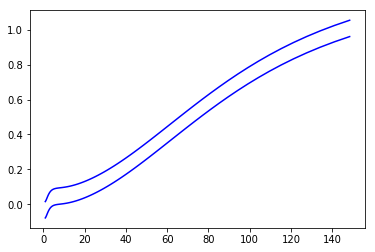

In [56]:
plt.plot(T, k - k_pl, color='b')
plt.plot(T, k, color='b')

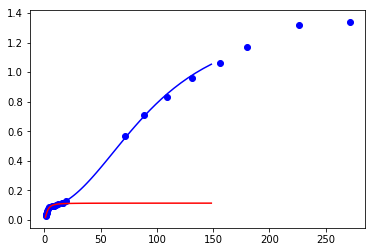

In [54]:
#plt.plot(T_bel_pl, k1(T_bel_pl, 0.4, 0.11, 1.8), color='g')
plt.scatter(data['T'], data['k'], color='b')
plt.plot(T, k, color='b')
plt.plot(T, k_fit, color='r')
# plt.xlim((0, 20)) 
# plt.ylim((0, 0.2)) 